# Submit a large batch of jobs to the Infinity SenseFit API

This notebook shows how to:
  1. Submit many (100s to 1000s) of jobs in batch mode to the Infinity SenseFit API to generate data with desired statistics/distributions
  2. Query the status of submitted jobs in non-blocking mode and download data as jobs complete
  3. Compile the dataset's metadata into a dataframe for easy summarization/querying
  
In particular, this notebook demonstrates the recommended workflow for submitting a large number of jobs in _non-blocking_ mode, such that the user can close the notebook and re-open it at a later time to query the jobs' statuses. The user can choose to download data as individual jobs complete, or wait until the entire batch has completed. 

Finally, we show how to compile a dataset's metadata into a dataframe for easy summarization and querying. This can be useful when training ML models, since it enables the user to look at the effect of different dataset parameters on model performance. For example, a user might want to train or evaluate a rep counting model on synthetic datasets with different rep speeds.

In [1]:
import numpy as np
from infinity_tools.sensefit import api
from infinity_tools.sensefit.vis import summarize_batch_results
from infinity_tools.common.api import Batch
from infinity_tools.common.vis import notebook

In [2]:
TOKEN = "YOUR_TOKEN_HERE"
output_dir = "./tmp/"

### Define distribution of parameters for the batch submission 

In this example, we will show how to create a large dataset of bicep curl recordings with the following constraints:
  - All sessions have 5 total reps
  - Even distribution of watch locations (left wrist vs. right wrist)
  - 75% of sessions have a standard watch orientation (crown facing the right); 25% have a reversed orientation (crown facing the left)
  - Uniformly distributed rep speeds (1 to 3 seconds/rep)
  - 50% of sessions have a fixed cadence across reps (no variation); 50% have maximum cadence variation across reps
  - 50% of sessions exhibit the exercise's full range of motion; 50% have a random amount of truncation to achieve variable range of motions
  - Data for all sessions is generated at 20 Hz
  
**Users can update the specification of `job_params` to fit their exact dataset needs.**

In [3]:
num_sessions = 150
job_params = []

for _ in range(num_sessions):    
    job_params.append(
        api.sample_rep_params(
            exercise="BICEP_CURL",
            num_reps=5,
            watch_location = np.random.choice(["LEFT", "RIGHT"]),
            crown_orientation = "RIGHT" if np.random.random() < 0.75 else "LEFT",
            seconds_per_rep = np.random.uniform(1,3),
            max_rel_speed_change = 0 if np.random.random() < 0.5 else 1.0,
            trim_start_frac = 0 if np.random.random() < 0.5 else None,
            trim_end_frac = 0 if np.random.random() < 0.5 else None,
            frames_per_second=20,
        )
    )

Before submitting our jobs to the API, we can visualize the distribution of their parameters:

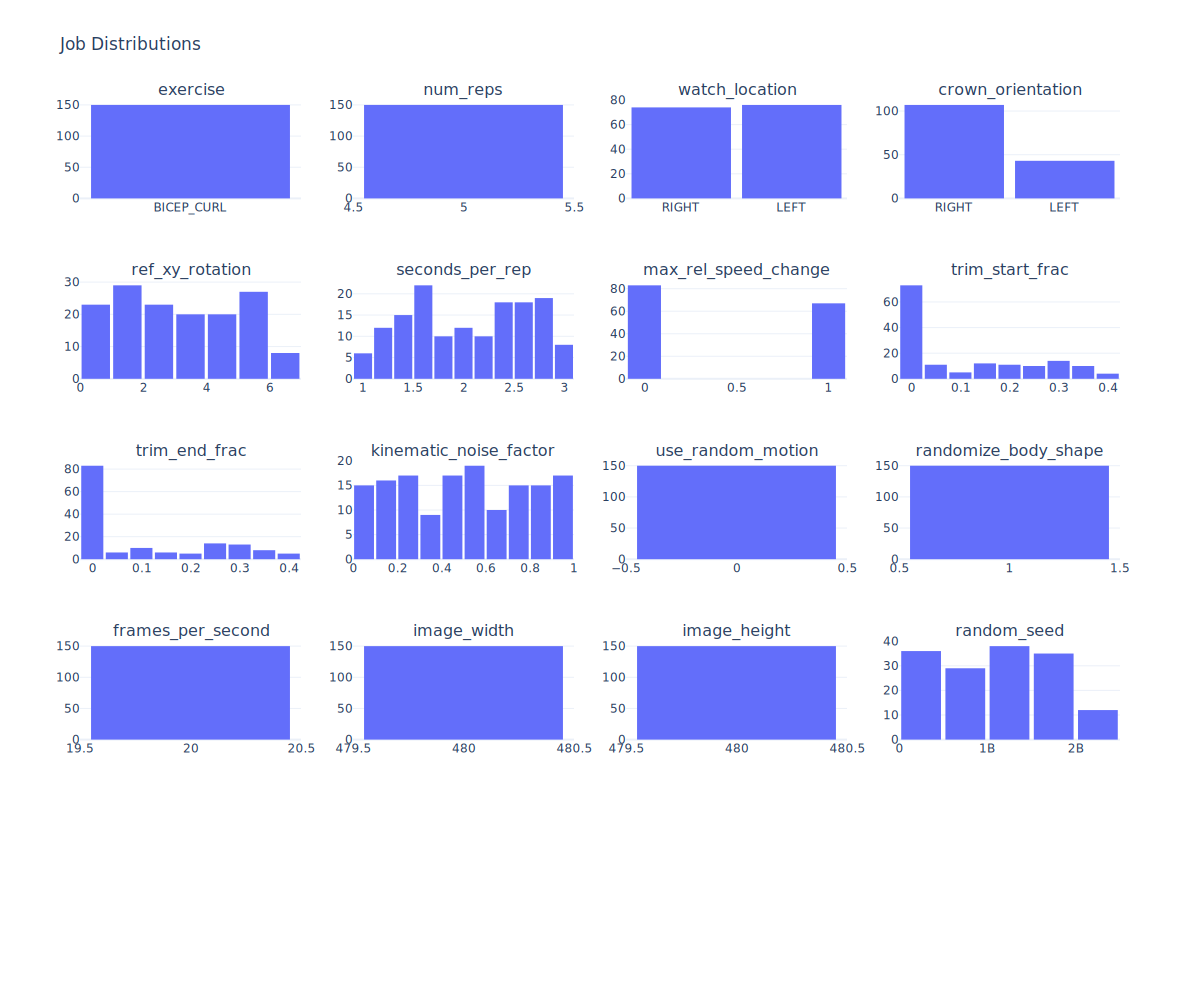

In [4]:
notebook.visualize_job_params(job_params)

### Submit batch of jobs to the API

With the parameters for each job defined, we can submit the jobs to the API as a single batch. After the jobs are submitted, the notebook can be closed and job statuses can be polled at a later time.

**NOTE: The batch name/folder should be recorded** so that it can be re-proceseed at a later time. A human-interpretable batch name can also be assigned to the batch (via `batch_folder_suffix`) to make its folder within the output directory more obvious.

In [5]:
batch_folder_suffix = "example_batch"
_, batch_folder = api.submit_batch_to_api(
    token=TOKEN,
    job_params=job_params,
    output_dir=output_dir,
    batch_folder_suffix=batch_folder_suffix,
)

print(batch_folder)

Submitting jobs to API...


  0%|          | 0/150 [00:00<?, ?it/s]

./tmp/20220503_T174017901018_example_batch


### Poll status of previously submitted jobs
We next show how to check on the status of a specific batch (potentially after closing and restarting this notebook). You only need to provide a path to the associated folder. Note that you can choose to move onto the next cell and download data before all jobs have successfully completed.

In [6]:
# replace `batch_folder` with desired batch folder
batch = Batch.from_batch_folder(batch_folder_path=batch_folder, token=TOKEN)

In [7]:
successful_jobs, failed_jobs = batch.get_completed_jobs_valid_and_invalid()

num_successful = len(successful_jobs)
num_failed = len(failed_jobs)
num_submitted = len(batch.job_ids)

print(f"{num_successful+num_failed}/{num_submitted} submitted jobs have completed.")
print(f"{num_successful}/{num_successful+num_failed} completed jobs have a valid URL.")

Polling status of jobs...


  0%|          | 0/150 [00:00<?, ?it/s]

150/150 submitted jobs have completed.
150/150 completed jobs have a valid URL.


### Download completed jobs

In [8]:
job_folders = api.download_completed_jobs(completed_jobs=successful_jobs, output_dir=batch_folder)

  0%|          | 0/150 [00:00<?, ?it/s]

### Visualize dataset statistics + filter for specific properties
Finally, we compile all of the job parameters that were submitted into a dataframe with any relevant metadata computed after job execution (e.g. the total number of frames). This allows us to understand the distribution of the resulting dataset. In addition, we can query the dataset for specific properties, which allows us to curate the desired training set for a given ML application.

In [9]:
df = summarize_batch_results(batch_folder)
df.head()

,job_id,num_frames,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,seconds_per_rep,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed
0,62abb3d8-6f80-4ccc-96bc-6a7cd5491099,130,BICEP_CURL,5,RIGHT,RIGHT,5.637007,1.303170,0.0,0.378061,0.085523,0.119128,False,True,20,480,480,349207064
1,da2a6eb4-415f-4d7f-a77a-29c2f830b568,265,BICEP_CURL,5,RIGHT,RIGHT,1.398627,2.663095,0.0,0.000000,0.301299,0.927221,False,True,20,480,480,1852766086
2,24cf2898-3bd1-44e8-8628-e792a50d71fe,112,BICEP_CURL,5,LEFT,RIGHT,5.549288,1.119310,0.0,0.000000,0.000000,0.602237,False,True,20,480,480,404003556
3,110c86a3-e3d9-47e0-8fd8-62a47f6ce937,251,BICEP_CURL,5,RIGHT,RIGHT,1.575958,2.719659,1.0,0.000000,0.000000,0.045228,False,True,20,480,480,2115770967
4,740d3e9a-dc8a-4232-a81f-f89590cfb33a,136,BICEP_CURL,5,LEFT,RIGHT,5.826251,1.363797,0.0,0.000000,0.122976,0.470965,False,True,20,480,480,2022611631


In [10]:
# make a sample query. you can use similar filters to curate the desired
# dataset for training an ML model.
df.query("seconds_per_rep < 2").query("num_frames > 150").query("watch_location == 'LEFT'").head()

,job_id,num_frames,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,seconds_per_rep,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed
8,74d94434-e23f-4173-9f8c-30f9a49d73b4,178,BICEP_CURL,5,LEFT,LEFT,6.124687,1.781273,0.0,0.076865,0.000000,0.277365,False,True,20,480,480,1243282538
10,ac85402d-999c-459b-bfa6-a148bb0fdc8c,196,BICEP_CURL,5,LEFT,RIGHT,5.290015,1.740012,1.0,0.000000,0.368412,0.683707,False,True,20,480,480,903528337
23,0f2baa74-ea51-4770-97b9-168dd63749b1,178,BICEP_CURL,5,LEFT,RIGHT,3.728961,1.044920,1.0,0.000000,0.000000,0.200306,False,True,20,480,480,1697224676
25,fd21c4af-add8-4344-b32a-eeefda095875,186,BICEP_CURL,5,LEFT,LEFT,2.326790,1.869962,0.0,0.247964,0.000000,0.051651,False,True,20,480,480,1312484950
32,78378a46-55ba-41d7-bd87-3608bebcba74,240,BICEP_CURL,5,LEFT,RIGHT,5.903001,1.934090,1.0,0.302689,0.137989,0.133068,False,True,20,480,480,1498935434
